In [1]:
#sottrarre media spike da ogni spike e guardare contenuto frequenze (rumore)
#ica

In [2]:
### clustering da vedere
### new new 

In [3]:
#un canale

In [4]:
#review codici spike sorting
# dati già classificati di spikes
# segno sia positivo che negativo dei picchi

In [5]:
from LibraryENGcopia import *
from tqdm import tqdm
import sklearn.preprocessing as ps
from sklearn.decomposition import PCA
from sklearn.cluster import DBSCAN
import numpy as np
import pandas as pd
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler
name_data = '2018-11-27T10-29-42POP 2 BL .h5'
name_data2 = '2018-11-27T12-03-02POP 2 stimulation.h5'
name_data3='2018-11-27T10-56-39MiP5 KA stimulation.h5'
complete_string='/Users/Gaia_1/Downloads/PoiProMEA-master/h5files/'+name_data
complete_string2='/Users/Gaia_1/Downloads/PoiProMEA-master/h5files/'+name_data2
complete_string3='/Users/Gaia_1/Downloads/PoiProMEA-master/h5files/'+name_data3

In [6]:
data = h5py.File(complete_string,'r')
#data = h5py.File(complete_string2,'r')
#data = h5py.File(complete_string3,'r')

data_readings = data['Data']['Recording_0']['AnalogStream']['Stream_0']['ChannelData'][()]
info = data['Data']['Recording_0']['AnalogStream']['Stream_0']['InfoChannel'][()]
info_table = pd.DataFrame(info, columns = list(info.dtype.fields.keys()))
labels = info_table['Label']
readings = pd.DataFrame(data = data_readings.transpose(), columns = labels)
fs = 10000 #Sampling Frequency
print(readings.shape)

(3717000, 60)


a = prova.values
dic = {"a": a, "label": "b'47'"}
dic

#dic=prova.to_dict()
#dic2=ref.to_dict()
scipy.io.savemat("matlab_matrix.mat", dic)
#scipy.io.savemat('ref.mat',dic2)

In [25]:
inizio=0
#fine=810000 #192 secondi
fine=len(readings)
prova_multi=readings.iloc[inizio:fine, :]
prova=prova_multi[b'47']
ref=readings[b'Ref']
ref=ref[inizio:fine]
#prova=readings.iloc[:150000, :5]
print(prova.shape,ref.shape)

(3717000,) (3717000,)


In [26]:
lowcut = 300
highcut = 3000
fs=10000
order=8
b,a=butter_bandpass(lowcut,highcut,fs,order=order)
filt_ref=filtfilt(b,a,ref)
filt_prova=filtfilt(b,a,prova)
f_prova = filt_prova - filt_ref
prova=f_prova
prova.shape
r_prova=prova.reshape(-1, 1)
scaler = StandardScaler()
s_prova = scaler.fit_transform(r_prova)
prova=s_prova
s_prova.shape

(3717000, 1)

In [27]:
minima,maxima=RMM(prova)
print(len(maxima))
#segnale BASELINE: firing rate=70 (spikes 26148)
#segnale Stimulation: firing rate=69 (spikes 32980)
#segnale KA stimulation: firing rate=81 (spikes 47860)

100%|█████████████████████████████▉| 3716689/3716700 [03:21<00:00, 18488.44it/s]

detected spikes: 26148 firing rate:  70.34705407586763
26148


In [28]:
minima,maxima=find_spikes(prova)
len(maxima)
#segnale BASELINE: firing rate=27 (spikes 10276)
#segnale Stimulation: firing rate=27 (spikes 13198)
#segnale KA stimulation: firing rate=32 (spikes 19178)

 91%|██████████████████████████▍  | 3387897/3716690 [00:22<00:02, 148154.52it/s]

detected spikes: 10276 firing rate:  27.645951035781543


10276

In [29]:
minima,maxima=find_spikes_with_memory(prova)
len(maxima)
#segnale BASELINE: firing rate=25 (spikes 9270)
#segnale Stimulation: firing rate=22 (spikes 10579)
# segnale KA stimulation: firing rate=8 (spikes 5054)

 83%|████████████████████████▊     | 3079137/3716690 [00:34<00:07, 89888.78it/s]

detected spikes: 9270 firing rate:  24.93946731234867


9270

In [30]:
def peak(x, minimal_dist=15, not_zero=1e-3):
    ## Get the first derivative
    dx = scipy.signal.fftconvolve(x,np.array([1,0,-1])/2.,'same')
    dx[np.abs(dx) < not_zero] = 0
    dx = np.diff(np.sign(dx))
    pos = np.arange(len(dx))[dx < 0]
    return pos[:-1][np.diff(pos) > minimal_dist]

In [39]:
sp0=peak(prova)

ValueError: in1 and in2 should have the same dimensionality

In [ ]:
def plot_data_list_and_detection(data_list, time_axes,evts_pos,linewidth=0.2,color='black'):
    nb_chan = len(data_list)
    data_min = np.min(data_list) 
    data_max = np.max(data_list) 
    display_offset = np.cumsum(np.array([0] +data_max- data_min))
    plt.plot(time_axes,data_list-display_offset,linewidth=linewidth,color=color)
    plt.plot(time_axes[evts_pos],data_list[evts_pos]-display_offset,'ro')
    plt.yticks([])
    plt.xlabel('Time (s)')

In [ ]:
plt.figure(figsize=(30, 15))
tt = np.arange(0,(len(prova))/10000)
plot_data_list_and_detection(prova,tt,sp0)

In [ ]:
firing_rate=len(sp0)*10000/len(prova)

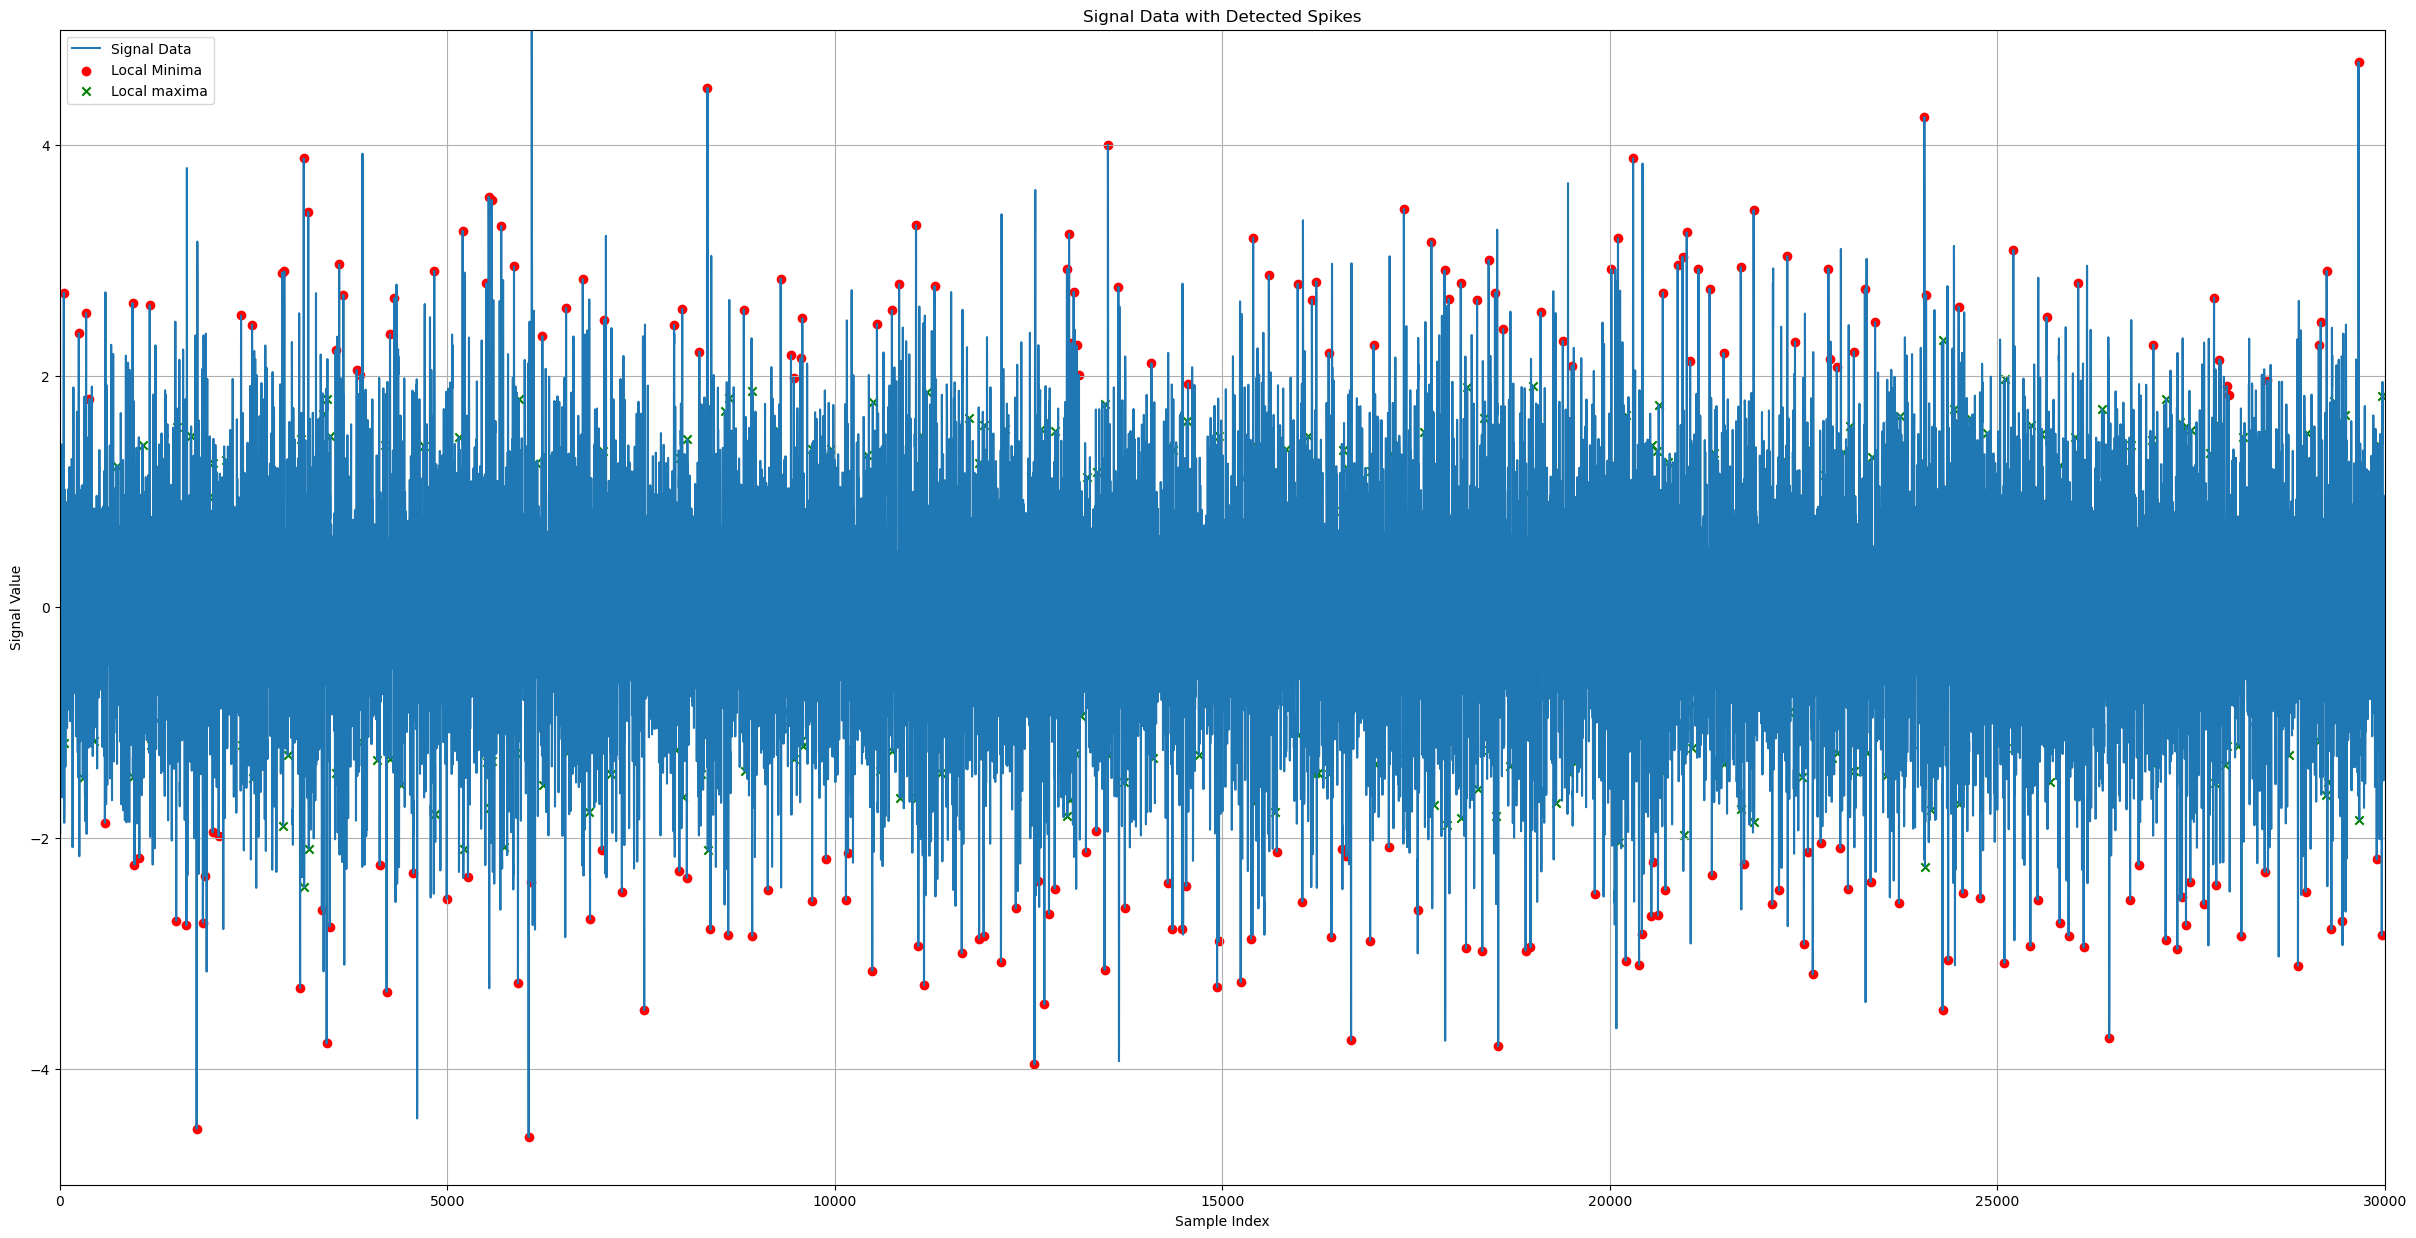

In [8]:
plt.figure(figsize=(30, 15))
plt.plot(prova, label='Signal Data')
plt.scatter(minima, [prova[i] for i in minima], c='red', marker='o', label='Local Minima')
plt.scatter(maxima, [prova[i] for i in maxima], c='green', marker='x', label='Local maxima')
plt.xlabel('Sample Index')
plt.ylabel('Signal Value')
plt.legend()
plt.grid(True)
plt.title('Signal Data with Detected Spikes')
plt.axis([0,30000,-5,5])
#plt.savefig('spikes.jpg')
plt.show()

# Cutouts

In [7]:
pre = 0.001
post = 0.002
prima = int(pre*fs)
dopo = int(post*fs)
lunghezza_indici = len(minima) #alligned indices
cutouts = np.empty([lunghezza_indici, prima+dopo])#, np.int32)
dim = prova.shape[0]
k=0
signal_mean=np.mean(prova)
signal_std=scipy.stats.median_abs_deviation(prova)
for i in minima:
    #verifico che la finestra non esca dal segnale
    if (i-prima >= 0) and (i+dopo <= dim):
        spike= s_prova[(int(i)-prima):(int(i)+dopo)].squeeze()
        media=(np.mean(spike))
        std=scipy.stats.median_abs_deviation(spike)
        #if media<=signal_mean and std<=3*signal_std:
        cutouts[k,:] = spike
        k += 1
print(np.isnan(cutouts).sum(),len(cutouts))
#plt.plot(cutouts[4])

0 5685


In [8]:
####rimuovere spike con media superiore a media del segnale e con std superiore a 3 volte std del segnale


es2: media -0.10468745229945865 std 0.9816428868475209


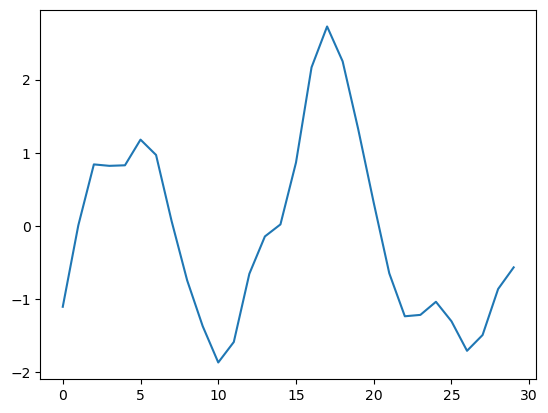

In [9]:
es2=cutouts[4]
std=scipy.stats.median_abs_deviation(es2)
mean=np.mean(es2)
print('es2:','media',mean,'std',std)
plt.plot(cutouts[4])

es5: 0.004001201982287787 1.3861347040090388


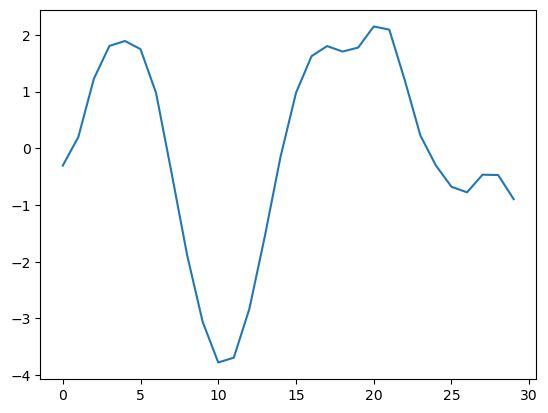

In [10]:
es5=cutouts[24]
std=scipy.stats.median_abs_deviation(es5)
mean=np.mean(es5)
print('es5:',mean,std)
plt.plot(cutouts[24])

es3: -0.2463153572981661 0.7735491391630922


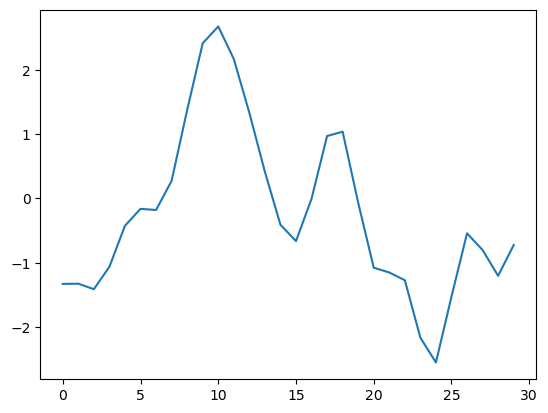

In [11]:
es3=cutouts[34]
std=scipy.stats.median_abs_deviation(es3)
mean=np.mean(es3)
print('es3:',mean,std)
plt.plot(cutouts[34])

es4: -0.11949210068856499 0.8537128951612803


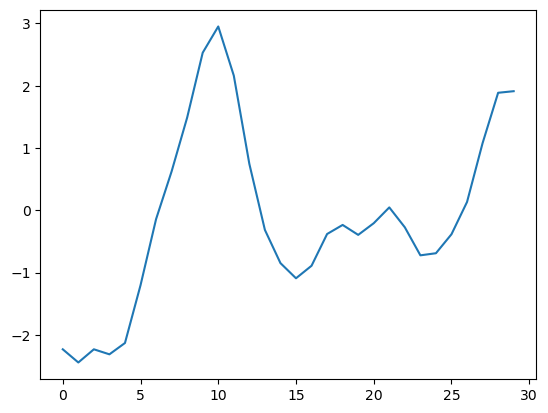

In [12]:
es4=cutouts[44]
std=scipy.stats.median_abs_deviation(es4)
mean=np.mean(es4)
print('es4:',mean,std)
plt.plot(cutouts[44])

es1: -0.19183347576977722 0.5074468625576818


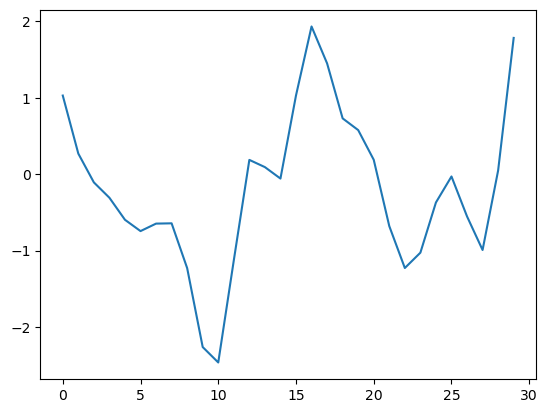

In [13]:
es1=cutouts[54]
std=scipy.stats.median_abs_deviation(es1)
mean=np.mean(es1)
print('es1:',mean,std)
plt.plot(cutouts[54])

In [14]:
signal_mean

1.1067141716090573e-17

# Clustering

In [15]:
#clustering='gerarchico'
n=2
#clustering='gaussianmixture'
#clustering='kmeans'
clustering='dbscan'

Total spikes:  5685
transformed

Spike detected as noise 1175

Number of clusters:  2 
The silhouette score is: 0.33107805187239303

Blue spikes: 2414

Orange spikes: 2096


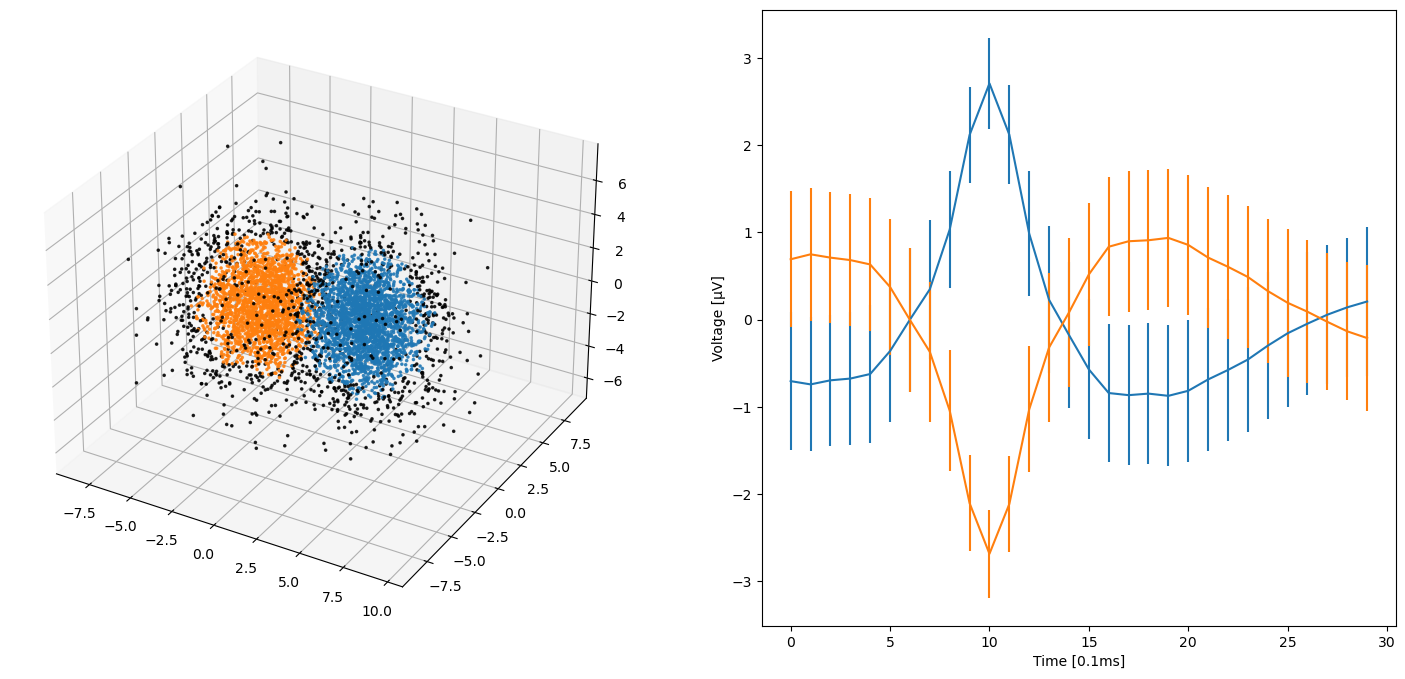

In [16]:
final_list=various_clustering(clustering,n,cutouts,minima,fs,n_comp=3,centroids=False)

In [18]:
final_list

[array([548890, 581669, 745514, 884779, 180273, 917565, 393287, 843845,
        786510, 778324, 532565,  16480, 761954, 139373, 352369,   8316,
        270464,  98436, 794758, 417933, 303249, 254112, 753829, 876731,
        499906, 843978,  16592,   8414, 696543, 352497, 909554, 147721,
        893206,  82199, 704800, 524578, 581927, 770353, 188744, 409941,
        917860, 696681, 319854, 221562, 287100, 573828, 754054, 369040,
        147864, 835992, 680346, 246178, 934305, 795054, 860602, 786881,
        729542, 958922, 508364, 172494, 213461,   8675, 303589, 393706,
        844268, 483835,  74240, 573956, 295436, 770575, 778799,  16947,
        205381, 819783, 827976, 696909, 352855, 361067, 893549, 475766,
        762490, 918147, 754313, 852631, 246426, 164509, 402084, 475838,
        320197, 606919, 844502, 795357, 500454, 287463, 156406, 623383,
        787227, 328485,  82726, 377638, 566063, 738099, 951090, 467772,
        901950, 222016, 680770, 279371, 230224, 705371, 107357, 

In [20]:
minima_pos=final_list[0]
minima_neg=final_list[1]
len(minima_pos)

1709

In [21]:
cutouts.shape

(2619, 30)

In [22]:
pre = 0.001
post = 0.002
prima = int(pre*fs)
dopo = int(post*fs)
lunghezza_indici = len(minima_pos) #alligned indices
pos_cutouts = np.empty([lunghezza_indici, prima+dopo])#, np.int32)
dim = prova.shape[0]
k=0
signal_mean=np.mean(prova)
signal_std=scipy.stats.median_abs_deviation(prova)
for i in minima_pos:
    #verifico che la finestra non esca dal segnale
    if (i-prima >= 0) and (i+dopo <= dim):
        spike= prova[(int(i)-prima):(int(i)+dopo)].squeeze()
        media=(np.mean(spike))
        std=scipy.stats.median_abs_deviation(spike)
        #if media<=signal_mean and std<=3*signal_std:
        pos_cutouts[k,:] = spike
        k += 1
print(np.isnan(pos_cutouts).sum(),len(pos_cutouts))
#plt.plot(cutouts[4])

0 1709


In [38]:
print(len(minima_pos),len(pos_cutouts))

4862 4862


Total spikes:  1709
transformed


/Users/Gaia_1/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1420: FutureWarning: algorithm='auto' is deprecated, it will be removed in 1.3. Using 'lloyd' instead.
  warnings.warn(


For 7 clusters, the silhouette score is: 0.2308885880746167




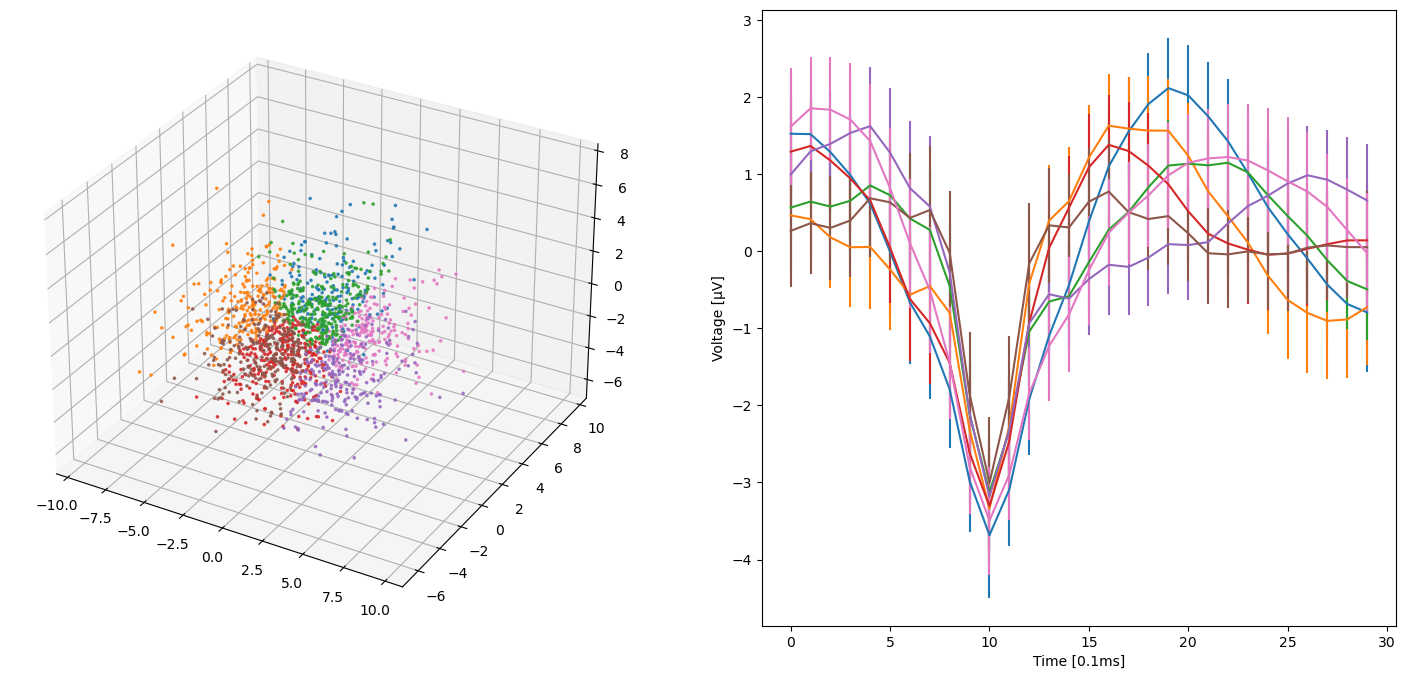

Trans shape:  (1709, 3)
Spike list:  1709


/Users/Gaia_1/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1420: FutureWarning: algorithm='auto' is deprecated, it will be removed in 1.3. Using 'lloyd' instead.
  warnings.warn(


In [36]:
n=7
pos_list=various_clustering(clustering,n,pos_cutouts,minima_pos,fs,n_comp=3,centroids=False)


Spike detected as noise 1369
1708

Number of clusters:  1 
The silhouette score is: -0.08459673994202199

Blue spikes: 340


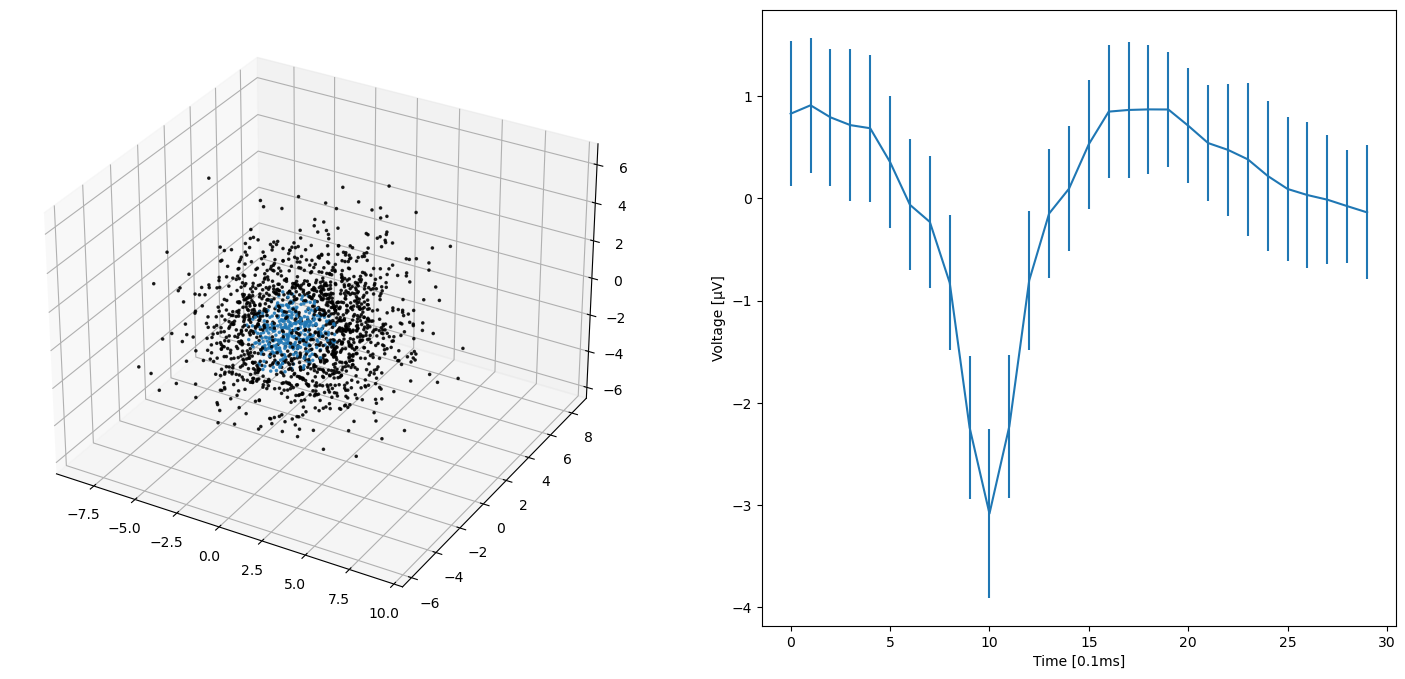

In [23]:
spike_list=minima_pos
pca = PCA(n_components=3)
pos_transformed = pca.fit_transform(pos_cutouts)
model = DBSCAN(eps=1.1, min_samples=60, metric='euclidean', metric_params=None, algorithm='auto', leaf_size=30, p=None, n_jobs=-1)
cluster_labels = model.fit_predict(pos_transformed)
final_list_dbscan=funzionedscan(pos_cutouts,pos_transformed,cluster_labels,minima_pos)


Spike detected as noise 1649

Number of clusters:  2 
The silhouette score is: 0.4281353892157213

Blue spikes: 5445

Orange spikes: 4596


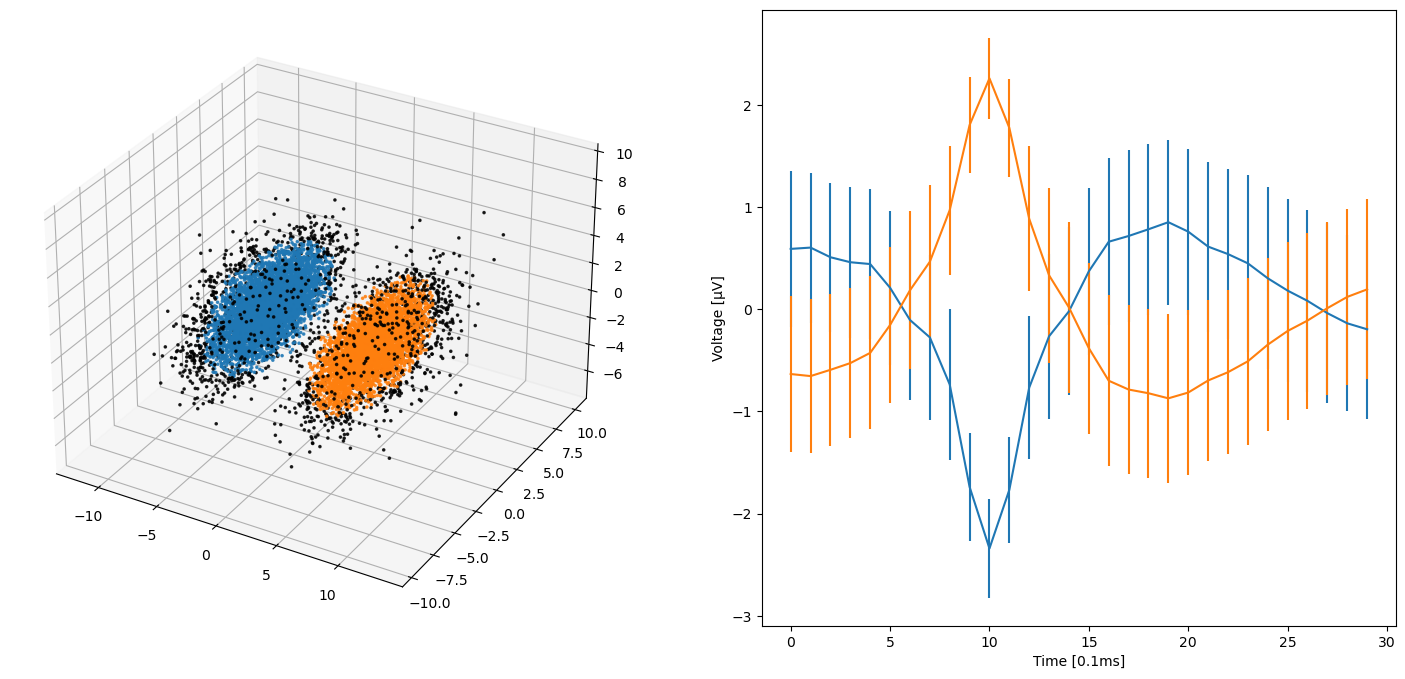

In [12]:
#scale = ps.StandardScaler()
#estratti_norm = scale.fit_transform(cutouts)
spike_list=minima
pca = PCA(n_components=3)
transformed = pca.fit_transform(cutouts)
model = DBSCAN(eps=1.1, min_samples=60, metric='euclidean', metric_params=None, algorithm='auto', leaf_size=30, p=None, n_jobs=-1)
cluster_labels = model.fit_predict(transformed)
final_list_dbscan=funzionedscan(cutouts,transformed,cluster_labels,minima)

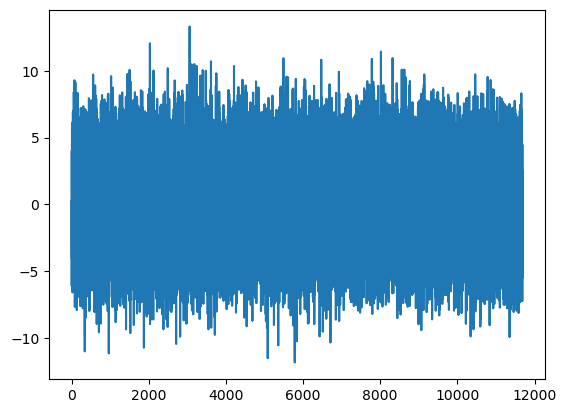

In [55]:
plt.plot(transformed[:,0])

In [54]:
transformed

array([[ 0.26229343, -0.01887342, -0.03732066],
       [-3.76603337, -0.8342754 ,  2.48532976],
       [-6.09426311, -1.05484762,  1.0792999 ],
       ...,
       [ 1.86086301,  0.67967051, -4.58231991],
       [-5.47846378, -3.2382005 , -0.19678216],
       [-3.39117234, -2.26916837, -0.01125169]])

In [16]:
for clu in final_list:
    print(len(clu))

2873
3177


In [18]:
final_list=final_list_dbscan
#final_list=final_list_gerarc
#final_list=final_list_kmeans
len(final_list)

3

In [16]:
neurons = []
for neuron in final_list:
    neurons.append(neuron)
nonoise_neurons=neurons[1:]
a=nonoise_neurons[0]
#b=nonoise_neurons[1]
noise=neurons[0]
#print(noise)
#print(neurons)
#print(nonoise_neurons)
#print('a',a)
#print('b',b)

(array([4.79889980e-08, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 5.61471276e-06, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 6.38253673e-06, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 6.14259174e-06,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 5.03884479e-06, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 5.13482278e-06, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 4.75091080e-06,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        4.75091080e-06, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 5.32677878e-06, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 3.98308683e-06,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        4.41498781e-06, 0.00000000e+00, 0.00000000e+00, 0.000000

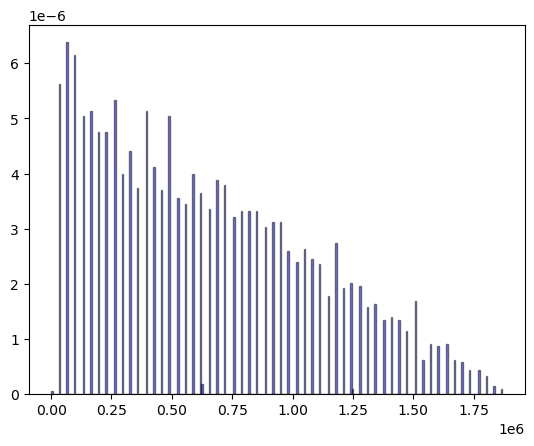

In [18]:
locs_diff=abs(np.diff(a))
#plt.axis([-3,500,0,0.05])
plt.hist(locs_diff, bins=300, density=True, alpha=0.5, color='blue', edgecolor='black')

(array([7.01905544e-03, 2.93389090e-03, 4.53081885e-03, 3.41668307e-03,
        3.11958019e-03, 3.16909734e-03, 2.69868445e-03, 2.31492657e-03,
        2.47585730e-03, 2.05496156e-03, 2.26540943e-03, 1.98068584e-03,
        1.58454867e-03, 1.52265224e-03, 1.22554936e-03, 1.34934223e-03,
        8.54170767e-04, 1.03986006e-03, 9.77963632e-04, 1.06461864e-03,
        6.93240043e-04, 7.30377902e-04, 9.16067200e-04, 5.07550746e-04,
        4.08516454e-04, 5.81826465e-04, 5.19930032e-04, 5.57067892e-04,
        4.08516454e-04, 2.84723589e-04, 3.58999308e-04, 2.59965016e-04,
        2.72344303e-04, 1.98068584e-04, 1.98068584e-04, 1.73310011e-04,
        2.35206443e-04, 8.66550054e-05, 1.48551438e-04, 1.73310011e-04,
        1.23792865e-04, 1.98068584e-04, 1.11413578e-04, 9.90342919e-05,
        6.18964324e-05, 8.66550054e-05, 1.11413578e-04, 6.18964324e-05,
        4.95171459e-05, 4.95171459e-05, 2.47585730e-05, 4.95171459e-05,
        4.95171459e-05, 2.47585730e-05, 4.95171459e-05, 0.000000

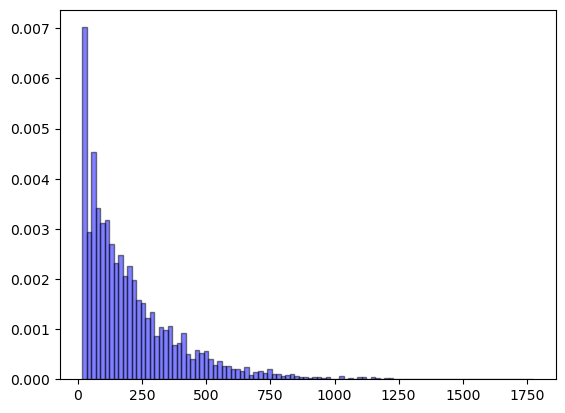

In [24]:
#b=sorted(b)
locs_diff=np.diff(b)
#plt.axis([-3,150,0,0.15])
plt.hist(locs_diff, bins=100, density=True, alpha=0.5, color='blue', edgecolor='black')

(array([7.93391053e-03, 6.70882140e-03, 4.08363042e-03, 5.43997909e-03,
        5.04620044e-03, 3.80652692e-03, 4.34614952e-03, 4.05446163e-03,
        3.68985177e-03, 3.48567025e-03, 3.04813842e-03, 2.59602219e-03,
        3.07730721e-03, 2.49393143e-03, 2.58143780e-03, 2.07098400e-03,
        1.98347763e-03, 2.28974991e-03, 1.69178974e-03, 1.66262096e-03,
        1.35634867e-03, 1.28342670e-03, 1.29801110e-03, 9.33401238e-04,
        8.89648055e-04, 1.12299836e-03, 1.21050473e-03, 1.00632321e-03,
        8.45894872e-04, 6.85466534e-04, 6.70882140e-04, 7.29219717e-04,
        5.97960168e-04, 4.08363042e-04, 5.39622591e-04, 2.77103493e-04,
        3.35441070e-04, 4.22947436e-04, 3.50025464e-04, 3.35441070e-04,
        2.91687887e-04, 2.33350310e-04, 2.33350310e-04, 1.31259549e-04,
        2.33350310e-04, 1.89597127e-04, 1.89597127e-04, 8.75063661e-05,
        1.16675155e-04, 1.16675155e-04, 1.60428338e-04, 1.02090760e-04,
        5.83375774e-05, 1.16675155e-04, 4.37531830e-05, 1.020907

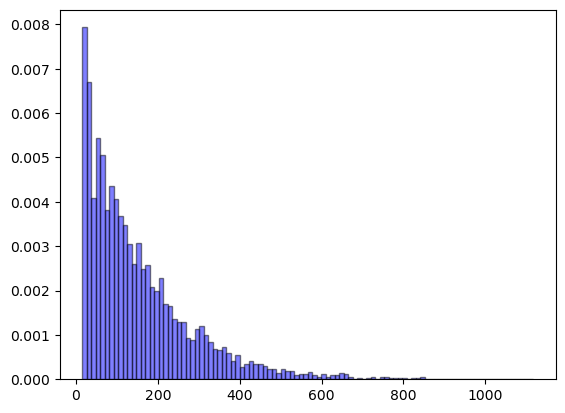

In [17]:
locs_diff=np.diff(noise)
#plt.axis([-3,150,0,0.15])
plt.hist(locs_diff, bins=100, density=True, alpha=0.5, color='blue', edgecolor='black')

In [ ]:
''''
#######PROBLEMI: 
√ local minima non sono per forza dei picchi negativi assoluti, bisogna mettere una condizione su quanto sia negativo
√ differential peak da vedere (mettere condizione con MAD? o con rapporto tra picco negativo e positivo?)
√ standardizzare prima (dopo aver filtrato)


''''

In [ ]:
adj_neur=[]

counter = 0
max_len=0

for neu in neurons:
    print('counter: ',counter,neu.shape[0])
    if neu.shape[0]>max_len:
        max_len=neu.shape[0]
    counter+=1
for neuron in neurons:
    if neuron.shape[0]<max_len:
        diff = max_len-neuron.shape[0]
        adj_neur.append(np.concatenate((neuron,np.zeros([diff]))))
    

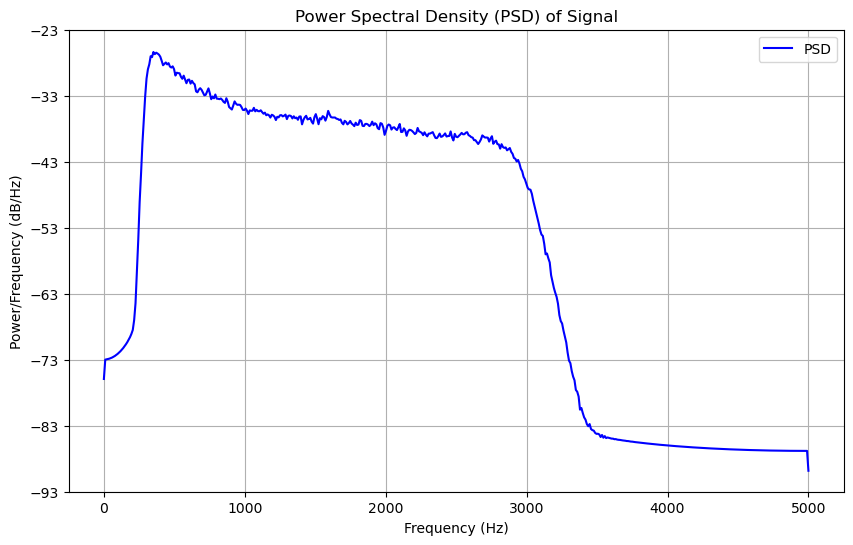

In [54]:
import numpy as np
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
plt.psd(s_prova.flatten(), NFFT=1024, Fs=fs, window=np.hamming(1024), noverlap=50, color='blue', label='PSD')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power/Frequency (dB/Hz)')
plt.title('Power Spectral Density (PSD) of Signal')
plt.grid(True)
plt.legend()
#plt.axis([140,160,-200,100])
plt.show()


In [129]:
###entrambi i segni
prova=s_prova
local_minima_indices = set()
peaks_mad=[]
last_50_indices = []
last_50_differences=[]
extracted=[]

# Set the window size and threshold
window_size = 50 #(100 samples 0.01 sec)
research_range = 100  # check for positive peak in the next 0.02 ms (200 samples)

for i in tqdm(range(0, len(prova) - window_size + 1)):
    window = abs(prova[i:i + window_size])
    min_index = np.argmax(window)
    local_minima_index = i + min_index
    local_min=prova[local_minima_index]
    if i<=50:
        mad=scipy.stats.median_abs_deviation(window)
        previous_thresh=3*mad
    if abs(local_min) >= previous_thresh:
        research_window = prova[local_minima_index + 1:local_minima_index + 1 + research_range]
        if local_min<0:
            max_index=np.argmax(research_window)
        else:
            max_index=np.argmin(research_window)
        local_max_index=i+max_index
        local_max=prova[local_max_index]
        diff=abs(local_min)+abs(local_max)
        if i<=50:
            d_thresh = scipy.stats.median_abs_deviation(research_window)
        if diff > 0.5*d_thresh:
            local_minima_indices.add(local_minima_index)
            i=local_max+1
            last_50_differences.append(diff)
            last_50_indices.append(local_minima_index)
            last_50_local_minima=abs(prova[last_50_indices])
            diff_mean=np.mean(last_50_differences)
            d_thresh=diff_mean
            peaks_mad=np.mean(last_50_local_minima)
            previous_thresh=peaks_mad
            if len(last_50_indices) > 50:
                last_50_indices.pop(0)
            if len(last_50_differences)>50:
                last_50_differences.pop(0)
        
unique_minima_indices = sorted(list(local_minima_indices))
print('detected spikes:',len(unique_minima_indices))



100%|████████████████████████████████████| 4451/4451 [00:00<00:00, 32930.83it/s]

detected spikes: 9


In [14]:
from tqdm import tqdm
prova=s_prova
local_minima_indices = set()
peaks_mad=[]
last_50_indices = []
extracted=[]

# Set the window size and threshold
window_size = 50 #(100 samples 0.01 sec)
research_range = 100  # check for positive peak in the next 0.02 ms (200 samples)

for i in tqdm(range(0, len(prova) - window_size + 1)):
    #print(i)
    window = prova[i:i + window_size]
    min_index = np.argmin(window)
    local_minima_index = i + min_index
    local_min=prova[local_minima_index]
    if i<=30:
        mad=scipy.stats.median_abs_deviation(window)
        previous_thresh=mad
    if local_min <= 1.1*previous_thresh:
        #print(previous_thresh)
        # Check values in the research range after the local minimum
        research_window = prova[local_minima_index + 1:local_minima_index + 1 + research_range]
        local_max_index=np.argmax(research_window)
        local_max=i+local_max_index
        local_max_value=prova[local_max]
        diff=abs(local_min-local_max)
        d_thresh = scipy.stats.median_abs_deviation(research_window)
        #### aggiungere un vettore che salva le differenze precedenti e mettere soglia in funzione di quello
        d=np.round(diff-d_thresh)
        #print(diff,d_thresh,d)
        if diff > (8* d_thresh):
            local_minima_indices.add(local_minima_index)
            #local_minima.add(prova)
            i=local_max+1
    #local_minima=set()
    last_50_indices.append(local_minima_index)
    #local_minima_indices_within_window = [idx for idx in last_50_indices if i <= idx < i + window_size]
    last_50_local_minima=prova[last_50_indices]
    #peaks_mad=scipy.stats.median_abs_deviation(last_50_local_minima)
    peaks_mad=np.mean(last_50_local_minima)
    previous_thresh=peaks_mad
    if len(last_50_indices) > 50:
        last_50_indices.pop(0)
        
unique_minima_indices = sorted(list(local_minima_indices))
print('detected spikes:',len(unique_minima_indices))



100%|█████████████████████████████████| 149951/149951 [00:15<00:00, 9627.71it/s]

detected spikes: 2241
